In [ ]:
"""IMPORTANT NOTES (Colab + Kaggle face-recognition-dataset)

- Cấu trúc tối thiểu cần có (theo notebook này):
  - Dataset.csv: cột `id` (tên file ảnh), `label` (tên lớp)
  - Faces/Faces/: chứa ảnh, filename khớp chính xác với `id` trong CSV
- Vì dùng VGG16 pretrained ImageNet, nên dùng `tf.keras.applications.vgg16.preprocess_input`
  (không chỉ /255.0) để khớp phân phối đầu vào.
- Đánh giá: dùng F1-score + confusion matrix đầy đủ (raw + normalized), ngoài accuracy.

"""

from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd

# Load the dataset CSV
dataset_path = '/content/drive/MyDrive/1015/ds_for_recog/Dataset.csv'
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Không tìm thấy Dataset.csv tại: {dataset_path}")

df = pd.read_csv(dataset_path)
required_cols = {'id', 'label'}
missing_cols = required_cols - set(df.columns)
if missing_cols:
    raise ValueError(f"Dataset.csv thiếu cột: {sorted(missing_cols)}")

print(df.head())
print(f"Tổng mẫu (CSV): {len(df)} | Số lớp: {df['label'].nunique()}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                        id             label
0  Robert Downey Jr_87.jpg  Robert Downey Jr
1       Lisa Kudrow_64.jpg       Lisa Kudrow
2   Ellen Degeneres_34.jpg   Ellen Degeneres
3      Billie Eilish_3.jpg     Billie Eilish
4    Hrithik Roshan_35.jpg    Hrithik Roshan
Tổng mẫu (CSV): 2562 | Số lớp: 31


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Drive đã được mount ở cell đầu. (Cell này giữ trống để tránh mount lặp)
pass

In [ ]:
from PIL import Image

image_dir = '/content/drive/MyDrive/1015/ds_for_recog/Faces/Faces'
if not os.path.isdir(image_dir):
    raise FileNotFoundError(f"Không tìm thấy thư mục ảnh tại: {image_dir}")

images: list[np.ndarray] = []
labels: list[str] = []
missing = 0

for _, row in df.iterrows():
    img_name = str(row['id'])
    label = str(row['label'])
    img_path = os.path.join(image_dir, img_name)

    if not os.path.exists(img_path):
        missing += 1
        continue

    # Luôn ép RGB để tránh lỗi ảnh grayscale/alpha
    img = Image.open(img_path).convert('RGB')
    images.append(np.array(img))
    labels.append(label)

print(f"Loaded {len(images)} images (missing: {missing}).")
print(f"Number of unique labels: {len(set(labels))}")


Loaded 2562 images (missing: 0).
Number of unique labels: 31


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input

# Define image size
# Gợi ý: VGG16 gốc train trên 224x224. 128 vẫn chạy được, nhưng thường kém hơn về chất lượng.
# Nếu Colab/VRAM cho phép, ưu tiên 224; nếu cần nhẹ hơn, thử 160 hoặc 192.
IMG_SIZE = 224

# Resize + preprocess theo VGG16
processed_images: list[np.ndarray] = []
for img in images:
    pil = Image.fromarray(img).convert('RGB')
    pil = pil.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(pil, dtype=np.float32)
    arr = preprocess_input(arr)  # expects RGB 0..255; outputs normalized for VGG16
    processed_images.append(arr)

X = np.stack(processed_images, axis=0)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
y = to_categorical(encoded_labels, num_classes=len(label_encoder.classes_))

# Split data into training and testing sets (stratify phải là 1D class index)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=encoded_labels,
)

print(f"IMG_SIZE: {IMG_SIZE}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


IMG_SIZE: 224
Shape of X_train: (2049, 224, 224, 3)
Shape of y_train: (2049, 31)
Shape of X_test: (513, 224, 224, 3)
Shape of y_test: (513, 31)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

# The model definition will be updated in the next step. For now, just setting up imports.

In [ ]:
# Load the VGG16 model with pre-trained ImageNet weights, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the convolutional layers of the base model
for layer in base_model.layers:
    layer.trainable = False

print("VGG16 base model loaded and layers frozen.")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
VGG16 base model loaded and layers frozen.


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Create the full model by adding new classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # gọn + ít overfit hơn Flatten
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

print("Classification head built on top of VGG16 (GAP head).")


Classification head built on top of VGG16 (GAP head).


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define callbacks
model_save_path = '/content/drive/MyDrive/1015/face_recognition_vgg16_model.keras'

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

checkpoint = ModelCheckpoint(
    filepath=model_save_path,
    monitor='val_loss',
    save_best_only=True,
)

print(f"Callbacks defined. Best model will be saved to: {model_save_path}")


Callbacks defined. Best model will be saved to: /content/drive/MyDrive/1015/face_recognition_vgg16_model.keras


In [ ]:
# Không lưu model ở đây vì model chưa train.
# Việc lưu sẽ được thực hiện sau khi train (ưu tiên định dạng .keras).
pass

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Display model summary
model.summary()

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, checkpoint],
)

print("Model training completed.")
print(f"Best model saved to: {model_save_path}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,853,983 (56.66 MB)

 Trainable params: 139,295 (544.12 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 271ms/step - accuracy: 0.0766 - loss: 5.2585 - val_accuracy: 0.3294 - val_loss: 2.4382
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.2687 - loss: 2.5232 - val_accuracy: 0.4561 - val_loss: 1.9099
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 0.4519 - loss: 1.8916 - val_accuracy: 0.5439 - val_loss: 1.5816
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.5005 - loss: 1.6459 - val_accuracy: 0.5575 - val_loss: 1.4468
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.5758 - loss: 1.3600 - val_accuracy: 0.6121 - val_loss: 1.2836
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.6005 - loss: 1.2692 - val_accuracy: 0.6101 - val_loss: 1.2393
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - accuracy: 0.6489 - loss: 1.1082 - val_accuracy: 0.6472 - val_loss: 1.1700
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.6907 - loss: 0.9601 - val_accu

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.7308 - loss: 0.8159
Test Loss: 0.8823
Test Accuracy: 0.7135


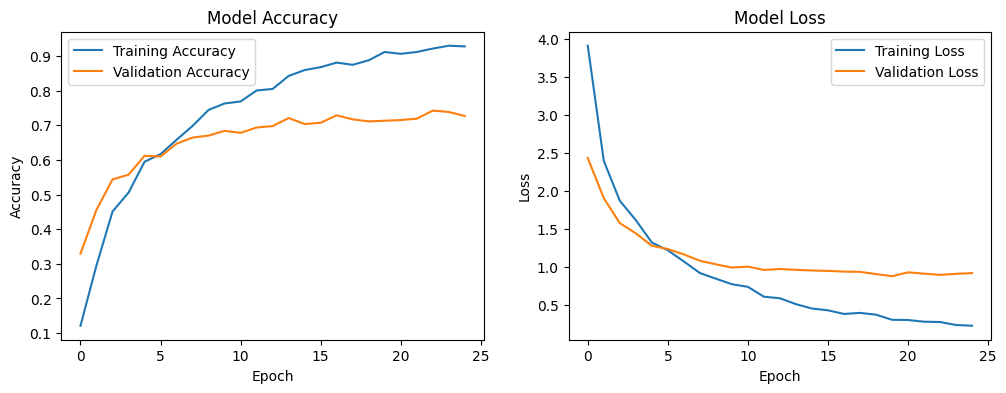

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


TEst


Test Loss: 0.8823
Test Accuracy: 0.7135
F1 macro   : 0.7059
F1 micro   : 0.7135
F1 weighted: 0.7076

=== Classification report ===
                    precision    recall  f1-score   support

      Akshay Kumar     0.7273    0.8000    0.7619        10
Alexandra Daddario     0.7857    0.6111    0.6875        18
        Alia Bhatt     0.5000    0.5625    0.5294        16
  Amitabh Bachchan     1.0000    1.0000    1.0000        15
      Andy Samberg     0.7778    0.7778    0.7778        18
    Anushka Sharma     0.4615    0.4286    0.4444        14
     Billie Eilish     0.7727    0.8500    0.8095        20
         Brad Pitt     0.7727    0.7083    0.7391        24
    Camila Cabello     0.7778    0.8235    0.8000        17
   Charlize Theron     0.3636    0.2500    0.2963        16
       Claire Holt     0.5200    0.6842    0.5909        19
      Courtney Cox     0.7059    0.7500    0.7273        16
    Dwayne Johnson     1.0000    0.9167    0.9565        12
   Elizabeth Olsen     1.000

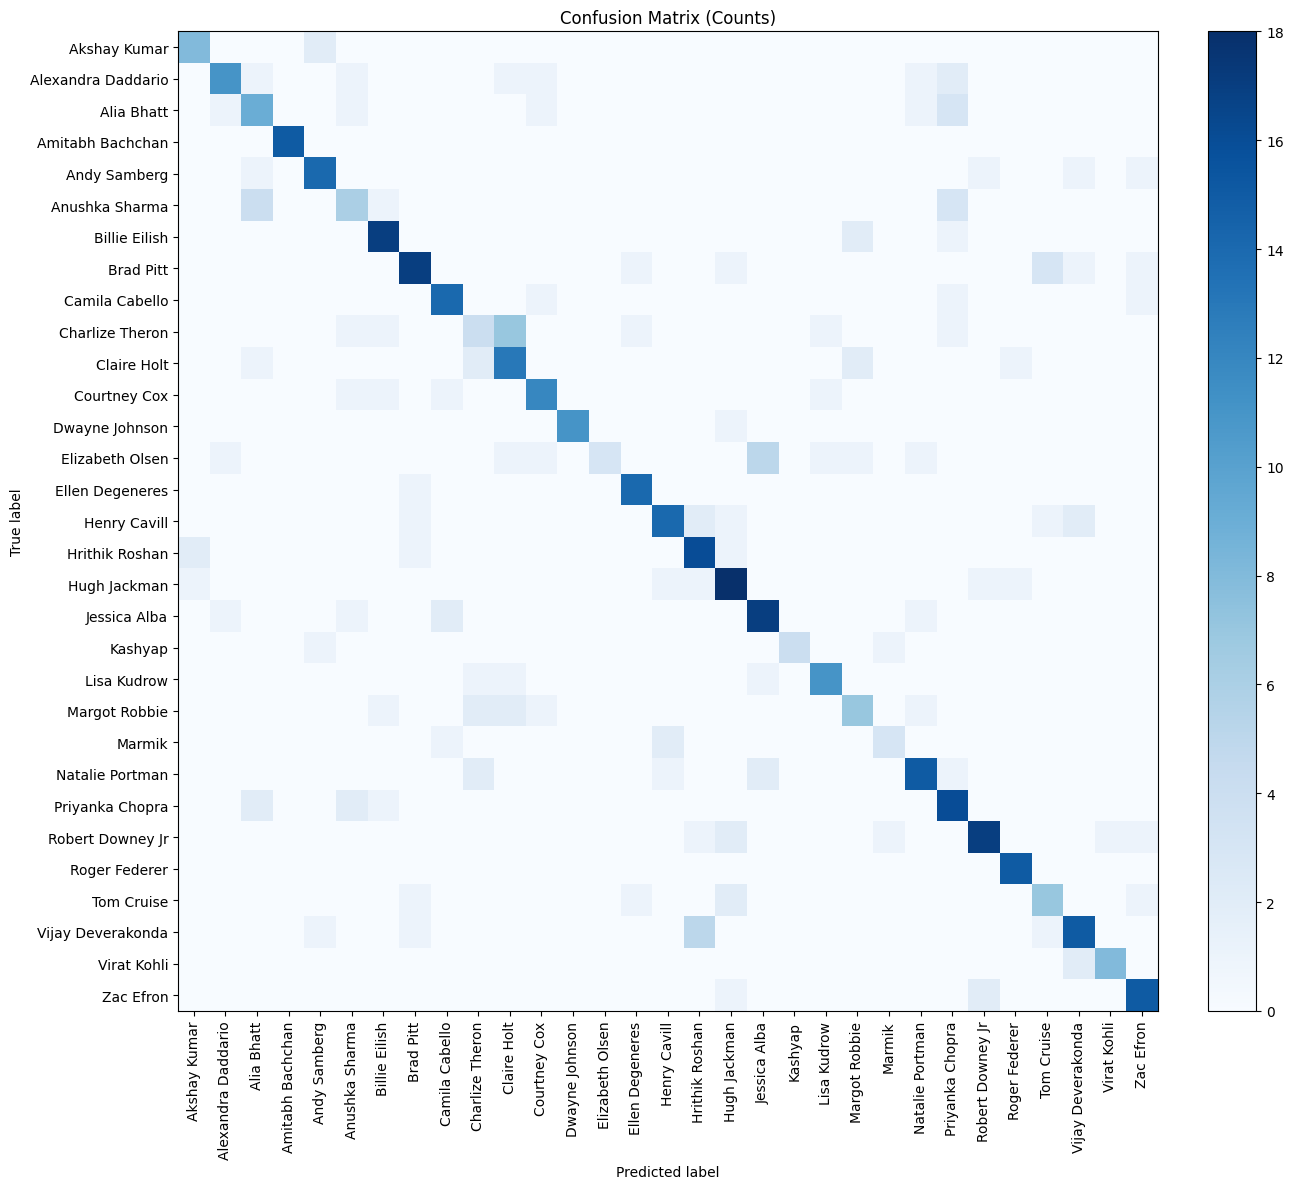

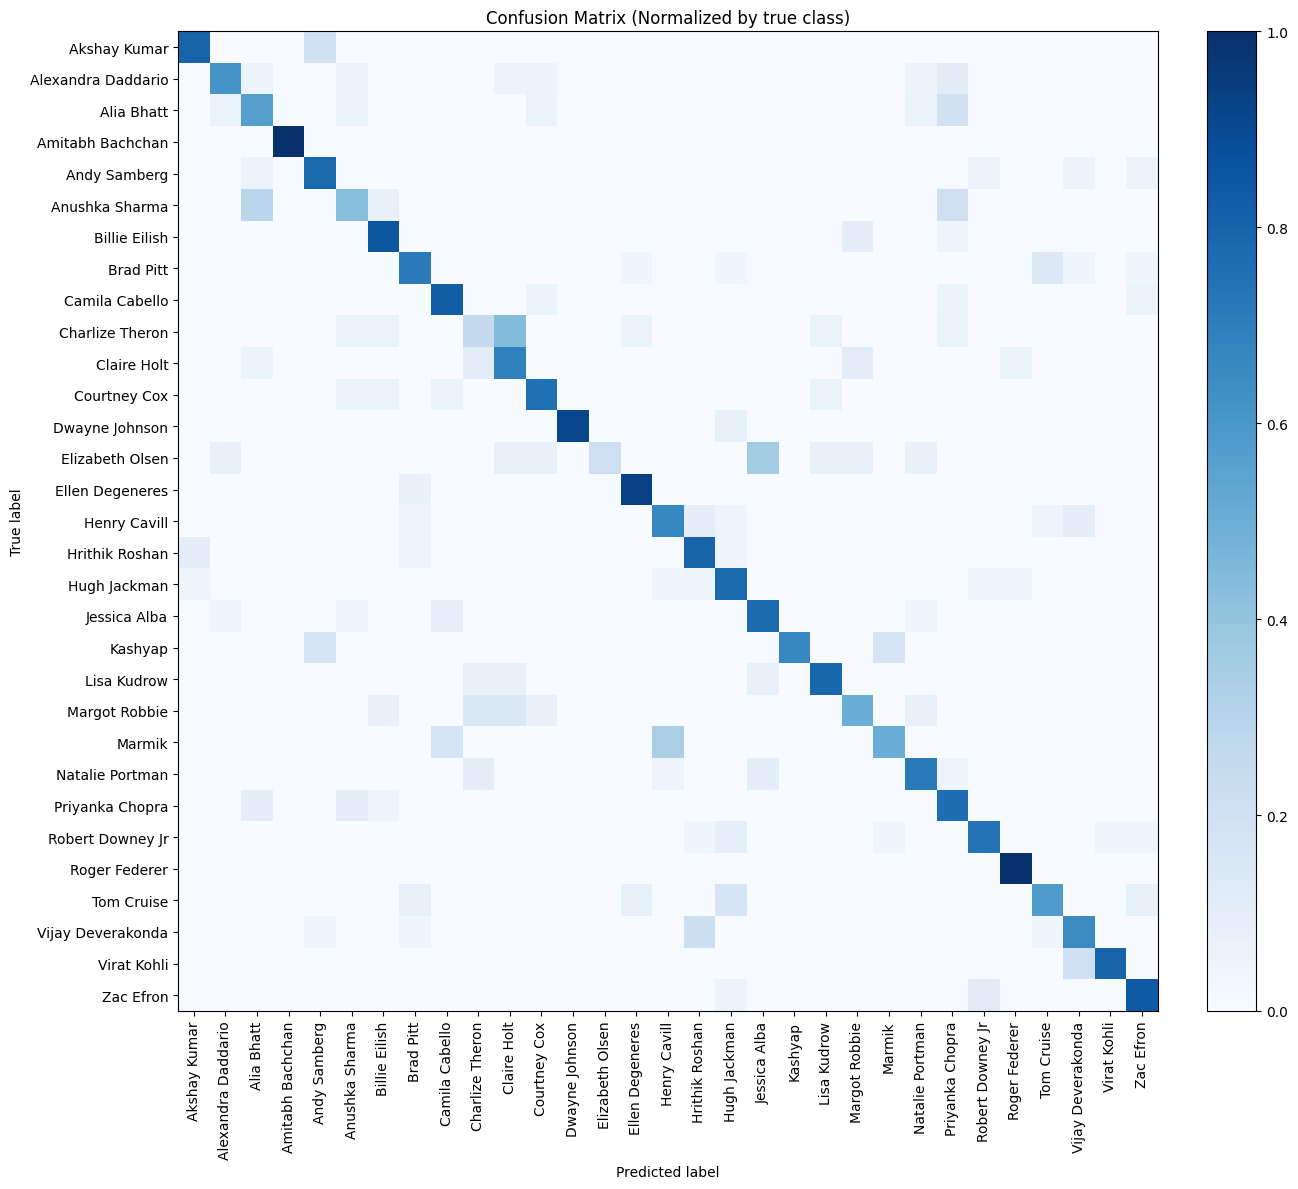


=== Worst recall classes (top 10) ===
Elizabeth Olsen           recall=0.214 | support=14
Charlize Theron           recall=0.250 | support=16
Anushka Sharma            recall=0.429 | support=14
Marmik                    recall=0.500 | support=6
Margot Robbie             recall=0.500 | support=14
Alia Bhatt                recall=0.562 | support=16
Tom Cruise                recall=0.583 | support=12
Alexandra Daddario        recall=0.611 | support=18
Vijay Deverakonda         recall=0.652 | support=23
Henry Cavill              recall=0.667 | support=21

=== Top confusions (count) ===
Charlize Theron -> Claire Holt : 7
Vijay Deverakonda -> Hrithik Roshan : 5
Elizabeth Olsen -> Jessica Alba : 5
Anushka Sharma -> Alia Bhatt : 4
Brad Pitt -> Tom Cruise : 3
Anushka Sharma -> Priyanka Chopra : 3
Alia Bhatt -> Priyanka Chopra : 3
Zac Efron -> Robert Downey Jr : 2
Virat Kohli -> Vijay Deverakonda : 2
Tom Cruise -> Hugh Jackman : 2
Robert Downey Jr -> Hugh Jackman : 2
Priyanka Chopra -> Anushka 

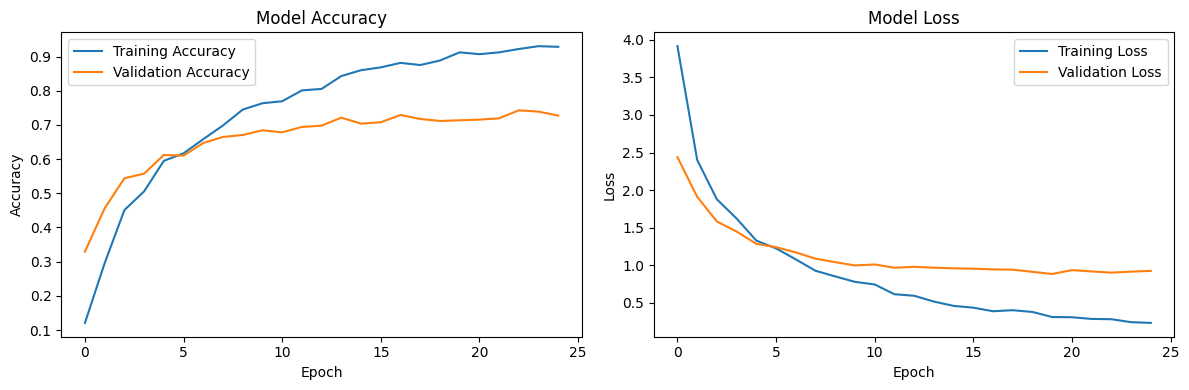

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# ===== Evaluate (Accuracy + F1 + Confusion Matrix) =====
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predict
y_prob = model.predict(X_test, verbose=0)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_prob, axis=1)

# F1 scores
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"F1 macro   : {f1_macro:.4f}")
print(f"F1 micro   : {f1_micro:.4f}")
print(f"F1 weighted: {f1_weighted:.4f}")

# Classification report
class_names = list(label_encoder.classes_)
print("\n=== Classification report ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# Confusion matrix (raw + normalized)
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype(np.float32) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

def plot_confusion_matrix(cm_to_plot, title: str, cmap='Blues'):
    plt.figure(figsize=(14, 12))
    plt.imshow(cm_to_plot, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, 'Confusion Matrix (Counts)')
plot_confusion_matrix(cm_norm, 'Confusion Matrix (Normalized by true class)')

# ===== Quick read: lớp nào đang kém + nhầm nhiều nhất =====
recall_by_class = np.diag(cm_norm)
worst_idx = np.argsort(recall_by_class)[:10]
print("\n=== Worst recall classes (top 10) ===")
for i in worst_idx:
    support = int(cm[i].sum())
    print(f"{class_names[i]:<25} recall={recall_by_class[i]:.3f} | support={support}")

cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)
confusions = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        c = int(cm_off[i, j])
        if c > 0:
            confusions.append((c, i, j))
confusions.sort(reverse=True)
print("\n=== Top confusions (count) ===")
for c, i, j in confusions[:15]:
    print(f"{class_names[i]} -> {class_names[j]} : {c}")

# ===== Plot training history =====
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import os
IMG_SIZE = 224
test_image_path = '/content/drive/MyDrive/1015/ds_for_recog/Faces/Faces/Alexandra Daddario_6.jpg' # Change this line!
# -------------------------------------
model_path = "/content/drive/MyDrive/1015/best_model.keras"
# Load the trained model
loaded_model = load_model(model_path)
loaded_model.summary()
# Load and preprocess the test image
try:
    img = Image.open(test_image_path)
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0 # Normalize pixel values
    img_input = np.expand_dims(img_array, axis=0) # Add batch dimension

    # Make prediction
    predictions = loaded_model.predict(img_input)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]
    confidence = np.max(predictions, axis=1)[0]

    print(f"Predicted label: {predicted_label} (Confidence: {confidence:.2f})")

    # Display the image with prediction
    plt.imshow(img_array)
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print(f"Error: Test image not found at {test_image_path}")
except Exception as e:
    print(f"An error occurred during prediction: {e}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,132,575 (57.73 MB)

 Trainable params: 139,295 (544.12 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 278,592 (1.06 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
An error occurred during prediction: name 'label_encoder' is not defined


Using runtime model (variable `model`).
Model input shape: (None, 224, 224, 3) | resize to: 224x224
File: Amitabh Bachchan_3.jpg
Top predictions:
   1. Amitabh Bachchan          prob=1.0000
   2. Hugh Jackman              prob=0.0000
   3. Tom Cruise                prob=0.0000
   4. Robert Downey Jr          prob=0.0000
   5. Brad Pitt                 prob=0.0000

Predicted label: Amitabh Bachchan (Confidence: 1.00)


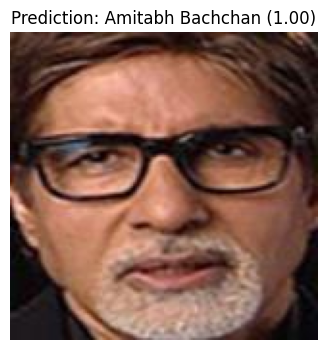

In [ ]:
"""IMPORTANT NOTES

- Cell này ưu tiên dùng **model đang có trong runtime** (biến `model` sau khi train).
- Nếu runtime không có `model`, mới fallback load từ `model_save_path`.
- Luôn preprocess đúng VGG16 (`preprocess_input`) và resize theo `model.input_shape`.

"""

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# Đổi ảnh ở đây
test_image_path = '/content/drive/MyDrive/1015/ds_for_recog/Faces/Faces/Amitabh Bachchan_3.jpg'

# Chọn model: ưu tiên model đang train trong runtime
predict_model = None
if 'model' in globals() and globals().get('model') is not None:
    predict_model = model
    print('Using runtime model (variable `model`).')
elif 'model_save_path' in globals() and os.path.exists(model_save_path):
    predict_model = load_model(model_save_path)
    print(f'Using saved model from: {model_save_path}')
else:
    raise FileNotFoundError('Không có model trong runtime và cũng không tìm thấy file model_save_path để load.')

# Auto IMG_SIZE theo model input
model_img_size = int(predict_model.input_shape[1])
print(f"Model input shape: {predict_model.input_shape} | resize to: {model_img_size}x{model_img_size}")

try:
    img = Image.open(test_image_path).convert('RGB')
    img_resized = img.resize((model_img_size, model_img_size))

    arr = np.array(img_resized, dtype=np.float32)
    arr_vgg = preprocess_input(arr)
    img_input = np.expand_dims(arr_vgg, axis=0)

    probs = predict_model.predict(img_input, verbose=0)[0]
    topk = 5
    top_idx = np.argsort(probs)[::-1][:topk]

    print(f"File: {os.path.basename(test_image_path)}")
    print("Top predictions:")
    for rank, idx in enumerate(top_idx, start=1):
        label = label_encoder.inverse_transform([int(idx)])[0]
        print(f"  {rank:>2}. {label:<25} prob={float(probs[idx]):.4f}")

    pred_idx = int(top_idx[0])
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    confidence = float(probs[pred_idx])
    print(f"\nPredicted label: {pred_label} (Confidence: {confidence:.2f})")

    # Hiển thị ảnh gốc
    plt.figure(figsize=(4, 4))
    plt.imshow(np.array(img))
    plt.title(f"Prediction: {pred_label} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print(f"Error: Test image not found at {test_image_path}")
except Exception as e:
    print(f"An error occurred during prediction: {e}")


In [ ]:
"""IMPORTANT NOTES

- Cell này dùng **file .keras** (checkpoint) để evaluate/predict.
- Nếu load trực tiếp từ Google Drive bị lỗi/partial, cell sẽ copy về `/content` rồi load.
- Cell này giả định bạn đã chạy các cell trước đó để có: `model_save_path`, `label_encoder`, `X_test`, `y_test`.

"""

import os
import shutil
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score

if 'model_save_path' not in globals():
    raise NameError("Chưa có `model_save_path`. Hãy chạy cell callbacks/train trước.")
if not os.path.exists(model_save_path):
    raise FileNotFoundError(f"Không tìm thấy file .keras tại: {model_save_path}")

local_model_path = '/content/best_model.keras'
shutil.copyfile(model_save_path, local_model_path)
file_model = load_model(local_model_path, compile=False)

print(f"Loaded .keras model from: {local_model_path}")
print(f"Input shape: {file_model.input_shape}")

# Quick evaluate (để so với runtime model)
y_prob = file_model.predict(X_test, verbose=0)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_prob, axis=1)

print(f"F1 macro   : {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 weighted: {f1_score(y_true, y_pred, average='weighted'):.4f}")

# (Optional) quick single-image predict using the same helper from cell 12
# Đặt đường dẫn ảnh bạn muốn test:
file_test_image_path = '/content/drive/MyDrive/1015/ds_for_recog/Faces/Faces/Alexandra Daddario_6.jpg'
print(f"\nTest image: {file_test_image_path}")

from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input

img = Image.open(file_test_image_path).convert('RGB')
img_size = int(file_model.input_shape[1])
img_resized = img.resize((img_size, img_size))
arr = np.array(img_resized, dtype=np.float32)
arr = preprocess_input(arr)
probs = file_model.predict(np.expand_dims(arr, 0), verbose=0)[0]

topk = 5
top_idx = np.argsort(probs)[::-1][:topk]
print("Top predictions (file model):")
for rank, idx in enumerate(top_idx, start=1):
    label = label_encoder.inverse_transform([int(idx)])[0]
    print(f"  {rank:>2}. {label:<25} prob={float(probs[idx]):.4f}")


Loaded .keras model from: /content/best_model.keras
Input shape: (None, 224, 224, 3)
F1 macro   : 0.7059
F1 weighted: 0.7076

Test image: /content/drive/MyDrive/1015/ds_for_recog/Faces/Faces/Alexandra Daddario_6.jpg
Top predictions (file model):
   1. Alexandra Daddario        prob=0.9361
   2. Jessica Alba              prob=0.0283
   3. Alia Bhatt                prob=0.0173
   4. Priyanka Chopra           prob=0.0082
   5. Elizabeth Olsen           prob=0.0034
